## Test case LVV-T30: Verify implementation of Wavefront Sensor Data Acquisition
Verify that the  DMS can acquire raw, full-frame exposures from the camera wavefront sensors <br>

Requirement:  DMS-REQ-0265
Derived from requirements: OSS-REQ-0316: Wavefront Sensor Data<br>

### Specification: 
The DMS shall acquire raw exposure data from the Camera wavefront sensors,<br>
during normal survey operations and in any other required operating modes.<br>

### Discussion:
The details of this are a matter for the DM-Camera ICD in this area. <br>
However,these data should be identical in format and in mode of acquisition to the raw science sensor data. <br>
There is no currently established requirement for the acquisition or archiving of any raw guider sensor data.

### Data 
The wavefront sensors are on the corner rafts: "R00", "R04", "R40", "R44" <br>
There are wavefront sensors on each corner raft: SW0/1: Science Wavefront 0/1 <br>
Wavefront sensors: "R00_SW0" (191), "R00_SW1" (192), 'R04_SW0" (195), "R04_SW1" (196), "R40_SW0 (199)", "R40_SW1(200)", "R44_SW0 (203)", "R44_SW1(204)" <br>
Wavefront sensor images are archived in multiple locations, but are currently not ingested into the Butler. <br> 

In [1]:
import os
import io
import numpy as np
import astropy.io.fits as pf
from astropy.table import Table
from astropy.io import fits
import pandas as pd
from pathlib import Path
import zipfile
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from lsst.rsp import get_tap_service

In [2]:
pd.set_option('display.max_columns', None) #all

In [3]:
# Day obs conversion 
def to_day_obs_int(dayobs):
    return int(dayobs.replace('-', ''))

In [4]:
# Open a zip file and extract the wavefront file data
def extract_wfs_images(filepath):
    wfs_images = [] 
    with zipfile.ZipFile(filepath, 'r') as zfile:
        for raft, ccd, detector in config:
            fits_file = Path(filepath).stem + '_' + raft + '_' + ccd + '.fits'
    
            # Read from the zipfile into memory
            with zfile.open(fits_file, 'r') as file:
                # Read the bytes and wrap in BytesIO to simulate a binary file
                file_data = io.BytesIO(file.read())
                wfs_img = fits.getdata(file_data)
                wfs_images.append({'image': wfs_img, 'label': raft + '_' + ccd})
    return wfs_images

In [5]:
# Plot the 8 wfs for an exposure
def plot_wfs(wfs_images):
    fig, axes = plt.subplots(2, 4, figsize=(10, 8))
    axes = axes.flatten()

    for i, wfs_img in enumerate(wfs_images):
        ax = axes[i]
        img = wfs_img['image']
        im = ax.imshow(img, 
                       vmin=np.percentile(img, 1), 
                       vmax=np.percentile(img, 99), 
                       cmap='gray')
        ax.set_title(wfs_img['label'])
        ax.axis('off')
        plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

In [6]:
# LSSTCam system integration start and end dates approximate
start_date = "2025-04-15" #first photon
end_date = date_str = (datetime.today() - timedelta(days=5)).strftime('%Y-%m-%d')

day_obs_start_science = to_day_obs_int(start_date) 
day_obs_start_lsstcam = to_day_obs_int(end_date)

In [7]:
# Wavefront config layout and sensor IDs
config = [['R40', 'SW0', 191], ['R40', 'SW1', 192], 
          ['R44', 'SW0', 195], ['R44', 'SW1', 196], 
          ['R00', 'SW0', 199], ['R00', 'SW1', 200],
          ['R04', 'SW0', 203], ['R04', 'SW1', 204]]
config_df = pd.DataFrame(config, columns=['raft', 'ccd', 'detector'])
wfs_ids = ', '.join(str(x) for x in config_df['detector'].tolist())

In [8]:
# Setup consdb
consdb = get_tap_service("consdbtap")
assert consdb is not None

In [9]:
# Get all science  exposures taken in LSSTCam commissioning for the wavefront sensors only 
# from the start of LSSTCam commissioning to now
instrument = "lsstcam"
table = 'ccdexposure'
query = f'''
SELECT  e.exposure_id, e.day_obs, e.seq_num, e.img_type, e.band, ccde.detector FROM cdb_{instrument}.{table} as ccde
JOIN cdb_{instrument}.exposure as e ON ccde.exposure_id = e.exposure_id
WHERE e.day_obs >= '{day_obs_start_science}' 
AND ccde.detector IN ({wfs_ids})
AND e.img_type IN ('science')
ORDER BY e.exposure_id DESC, e.img_type, e.band, ccde.detector ASC
'''
df = consdb.search(query).to_table().to_pandas()

## Stats on the wavefront sensors images

In [10]:
# Total 
total_images = df['exposure_id'].nunique()
print(f"There are {len(df)} wavefront sensor images in {total_images} unique science exposures collected from {start_date} throught {end_date}")

There are 172728 wavefront sensor images in 21591 unique science exposures collected from 2025-04-15 throught 2025-08-16


In [11]:
# Number of wavefront sensors per exposure
n_wfs_per_exposure = df.groupby('exposure_id')['detector'].size().reset_index(name='n_wfs')
n_wfs_per_exposure.sample(5)
missing_wfs = n_wfs_per_exposure[n_wfs_per_exposure['n_wfs'] != 8]
assert len(missing_wfs)== 0
print(f"All exposures contain 8 wfs ccd images")

All exposures contain 8 wfs ccd images


In [12]:
# Path template at USDF where the ancillary data are archived as ZIP files:
filepath_template = ("/sdf/data/rubin/lsstdata/offline/instrument/LSSTCam/{day_obs}/MC_O_{day_obs}_{seq_num:06d}.zip")

Inspecting: /sdf/data/rubin/lsstdata/offline/instrument/LSSTCam/20250501/MC_O_20250501_000584.zip


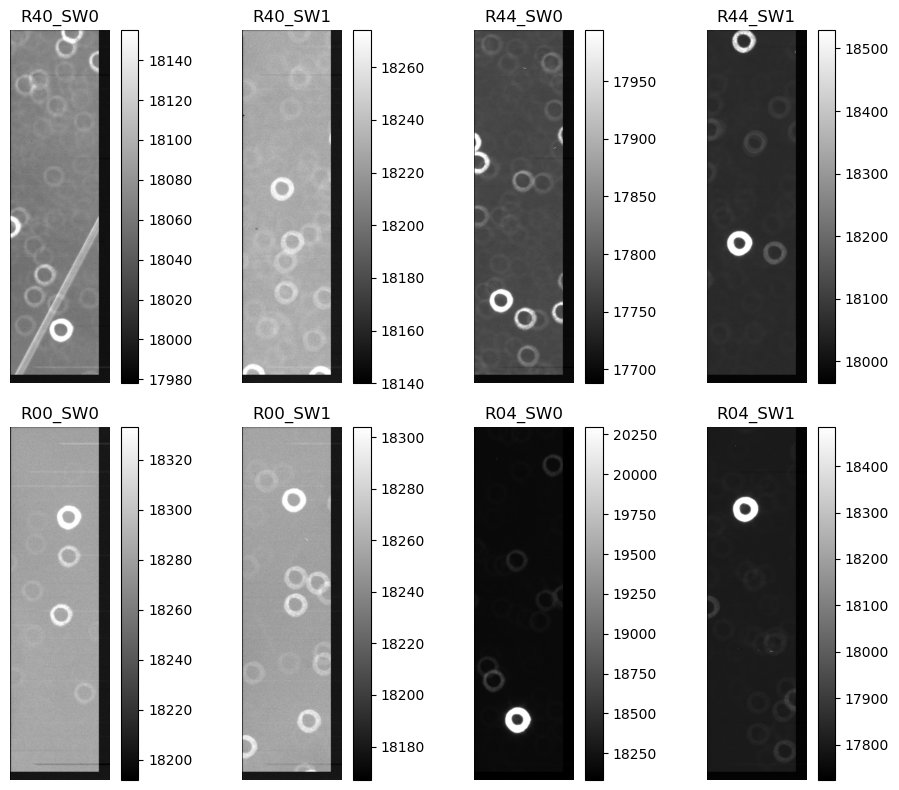

Inspecting: /sdf/data/rubin/lsstdata/offline/instrument/LSSTCam/20250506/MC_O_20250506_000777.zip


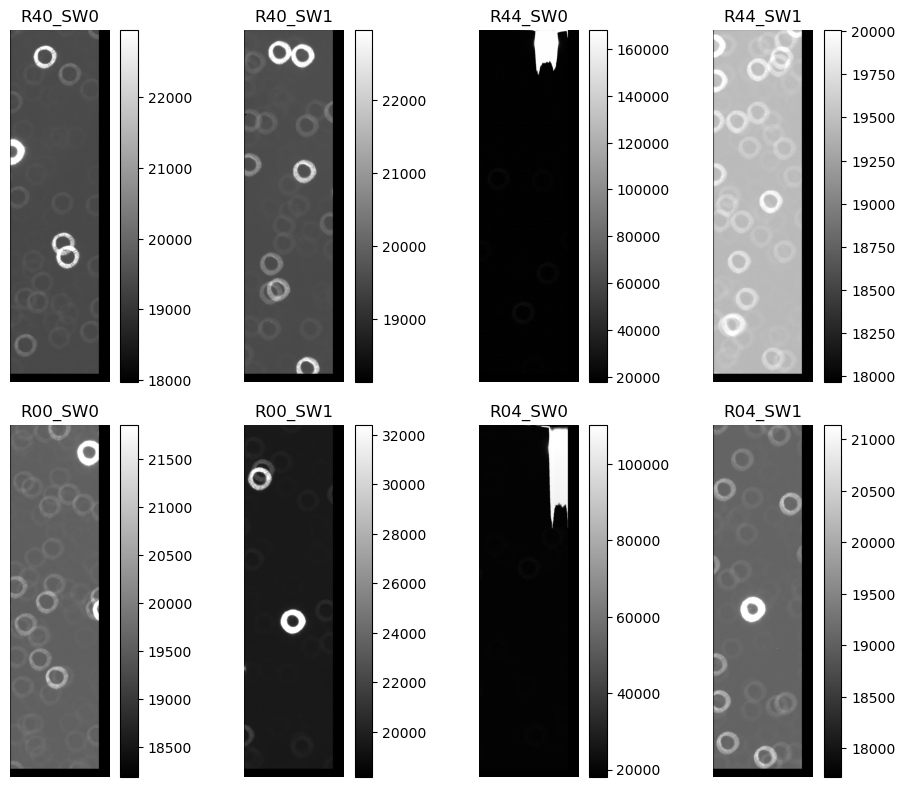

Inspecting: /sdf/data/rubin/lsstdata/offline/instrument/LSSTCam/20250814/MC_O_20250814_000295.zip


In [ ]:
# Take a random few exposures and look at the images
exps = df.sample(3)
for _, exp in exps.iterrows():
    file_path = Path(filepath_template.format(
        day_obs=exp['day_obs'],
        seq_num=exp['seq_num']))

    if file_path.exists():
        print(f"Inspecting: {file_path}")
        # Extract images and plot
        wfs_images = extract_wfs_images(file_path)
        plot_wfs(wfs_images)
    else:
        print(f"Skipping missing file: {file_path}")